In [ ]:
import torch
import math
import matplotlib.pyplot as plt
torch.set_printoptions(profile="full")


In [ ]:
# R = P0 + e, ks, kf1, kb1
# P0 = 2P1, kf2, kb2, deltaG2, deltaH, deltaS

In [ ]:
#physical Constants
F = 96485.332 #C/mol - Faraday constant
T = 298 #K - Temperature
R = 8.314 #J/mol-K - Gas const.
Beta = 0.5 #grid expansion factor 0 < BT < 1

#reaction Constants
DR = 1e-9 #m^2/s - Diffusion coeff of reactant R
DP = 1e-9 #m^2/s - Diffusion coeff of reactant P
ks = 1e-9 #m^2/s - Surface rate constant (max value ~ 1 m^2/s)
kdiff = 7.9e9  #s-1 - diffusion rate constant

In [ ]:
#calculate reaction constants
k2f = 0.1 # s-1
k2b = 0 # M-1 s-1

In [ ]:
#experiment constants
nu = 0.1 #V/s- Sweep rate
Ei = 2.0 #V - initial voltage
E0 = 2.5 #V - thermodynamic reversible potential
Emax = 4.0 #V - Max voltage (end for forwards sweep
Emin = 1.0 #V - Min voltage (end for backwards sweep)
dE = 0.001 #V - potential step
CR0 = 0.01 #M - bulk conc. of reactant R - MUST have a decimal!
CP00 = 0 #M - bulk conc. of product P0
CP10 = 0 #M - bulk conc. of product P1
#CP20 = 0 #M - bulk conc. of product P2
Alpha = 0.5 #Transfer coefficient
n = 1 # # of electrons transferred
VT = Alpha*n*F/(R*T) #V -mod. thermal voltage for n = 1

In [ ]:
dt = 0.001
dx = 7.021045531185578e-10
Ds = max([DR, DP]) * dt / (dx * dx)
print("Ds =", Ds)

tf = (Emax-Emin) / nu #s, timescale of experiment operation
xmax = 6.0*math.sqrt(max([DR,DP])*tf) #maximum diffusion distance
N = 1 + math.ceil(math.log(1 + (xmax*(math.exp(Beta) - 1)/dx) )/Beta)  #+1 for ghost pt

print("N =", N)
print("xmax =", xmax)

Ds = 2028600.0000000005
N = 29
xmax = 0.0010392304845413263


In [ ]:
#create the array of space
x = torch.empty(3*(N+1), 1, dtype = torch.double)
x[0] = 0
for k in range(1, 1+N):
  x[k] = dx * (math.exp(Beta*(k-0.5))-1) / (math.exp(Beta)-1)
for k in range(1+N, 2*N+2):
  x[k] = x[k-N-1]
for k in range(2*(N+1), 3*(N+1)):
  x[k] = x[k-2*N-2]

print(x.shape)

torch.Size([90, 1])


In [ ]:
#calculate the normalized rate constant
dx1 = dx * (math.exp(Beta/2)-1)/(math.exp(Beta)-1)

k1f = ks * math.exp((Ei-E0)*VT) * dx1 / DR
k1b = ks * math.exp(-(Ei-E0)*VT) * dx1 / DP
k2fs = k2f * dt
k2bs = k2b * dt

print(k1f)
print(k1b)
print(k2fs)
print(k2bs)

1.817455429474267e-14
5.199217009382569e-06
0.0001
0.0


In [ ]:
#create tensors for the new concentration
Cnew = torch.empty(3*(N+1), 1, dtype = torch.double)
Cnew[0:N] = CR0
Cnew[N+1 : 2*N+1] = CP00
Cnew[2*N+2 : 3*N+2] = CP10

#create tensors for the old concentrations
ColdR = torch.empty(N+1, 1, dtype = torch.double)
ColdR.fill_(CR0)

Cold0 = torch.empty(N+1, 1, dtype = torch.double)
Cold0.fill_(CP00)

Cold1 = torch.empty(N+1, 1, dtype = torch.double)
Cold1.fill_(CP10)

#create tensors for the old concentration
Cold = torch.empty(3*(N+1), 1, dtype = torch.double)

Cold[0:N] = ColdR[0:N]
Cold[N+1 : 2*N+1] = Cold0[0 : N] - k2bs * Cold1[0 : N] * Cold1[0 : N]
Cold[2*N+2 : 3*N+2] = Cold1[0 : N] + k2bs * Cold1[0 : N] * Cold1[0 : N]
#Cold[3*N+3 : 4*N+3] = Cold2[0 : N] + k2bs * Cold1[0 : N] * Cold2[0 : N]

Cold[0] = 0
Cold[N+1] = 0
Cold[2*N+2] = 0
Cold[N] = CR0
Cold[2*N+1] = CP00
Cold[3*N+2] = CP10


In [ ]:
#create tensors for the diffusion coefficients
D1 = torch.empty(N, 1, dtype = torch.double)
D2 = torch.empty(N, 1, dtype = torch.double)
D3 = torch.empty(N, 1, dtype = torch.double)

#set values for the diffusion coefficients
D1[0] = Ds * (math.exp(Beta)-1) / (math.exp(Beta/2) - 1)
D2[0] = Ds * math.exp(2*Beta*(3/4 - 1))
D3[0] = D1[0] + D2[0] + 1

for k in range(1, N):
  D1[k] = Ds * math.exp(2 * Beta * (5/4 - k - 1))
  D2[k] = Ds * math.exp(2 * Beta * (3/4 - k - 1))
  D3[k] = D1[k] + D2[k] + 1

In [ ]:
#create a tensor size (4N+4)*(4N+4) with uninitialized memory
Dopt = torch.empty(3*(N+1), 3*(N+1), dtype=torch.double).fill_(0)
Drat = DR/DP

#set values for the operator Dopt

#set values for row 0
Dopt[0] = 0
Dopt[0, 0] = math.exp(n * F * (Ei - E0) / (R * T))
Dopt[0, N+1] = - 1

#print(Dopt[0])

In [ ]:
#set values for row N+1
Dopt[N+1] = 0
Dopt[N+1, 0] = -Drat
Dopt[N+1, 1] = Drat
Dopt[N+1, N+1] = -1
Dopt[N+1, N+2] = 1

#print(Dopt[N+1])

In [ ]:
#set values for row 2*(N+1)
Dopt[2*N+2] = 0
Dopt[2*(N+1), 2*(N+1)] = 1
Dopt[2*(N+1), 2*(N+1)+1] = -1


In [ ]:
#set values for row N
Dopt[N] = 0
Dopt[N, N] = 1

#set values for row 2N+1
Dopt[2*N+1] = 0
Dopt[2*N+1, 2*N+1] = 1

#set values for row 3*(N+1)-1
Dopt[3*N+2] = 0
Dopt[3*(N+1)-1, 3*(N+1)-1] = 1

#print(Dopt[N])
#print(Dopt[2*N+1])
#print(Dopt[3*N+2])

In [ ]:
#set values for other rows for Dopt
for i in range(1, N):
  Dopt[i] = 0
  Dopt[i, i] = D3[i-1]
  Dopt[i, i-1] = -D1[i-1]
  Dopt[i, i+1] = -D2[i-1]

for i in range(N+2, 2*N+1):
  Dopt[i] = 0
  Dopt[i, i] = D3[i-N-2] + k2fs
  Dopt[i, i-1] = -D1[i-N-2]
  Dopt[i, i+1] = -D2[i-N-2]
  Dopt[i, i+N+1] = -2 * k2bs * Cold1[i-N-1]

for i in range(2*N+3, 3*N+2):
  Dopt[i] = 0
  Dopt[i, i] = D3[i-2*N-3] + 2 * k2bs * Cold1[i-2*N-2]
  Dopt[i, i-1] = -D1[i-2*N-3]
  Dopt[i, i+1] = -D2[i-2*N-3]
  Dopt[i, i-N-1] = -k2fs

print(Dopt.shape)

torch.Size([90, 90])


In [ ]:
#Initialize potential vector
Evt = torch.cat([torch.arange((Ei+dE),(Emax+dE),dE), torch.arange(Emax, (Emin-dE), -dE), torch.arange(Emin, (Emax+dE), dE), torch.arange(Emax, (Emin-dE), -dE), torch.arange(Emin, (Ei+2*dE), dE)])

Evt = Evt.reshape(len(Evt),1)
print(Evt.shape)
Istor = 0.0*Evt
count = 0

torch.Size([12007, 1])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


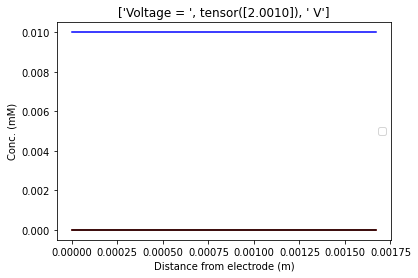

0 tensor([2.0010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


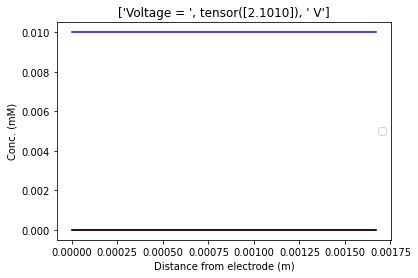

100 tensor([2.1010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


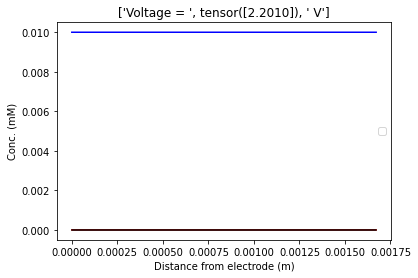

200 tensor([2.2010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


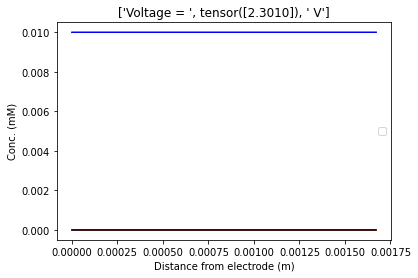

300 tensor([2.3010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


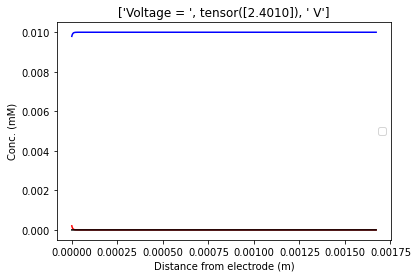

400 tensor([2.4010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


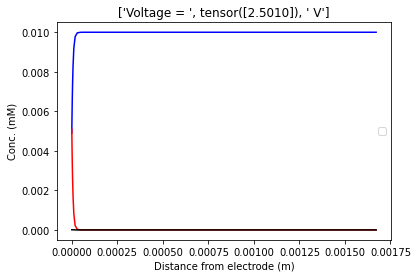

500 tensor([2.5010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


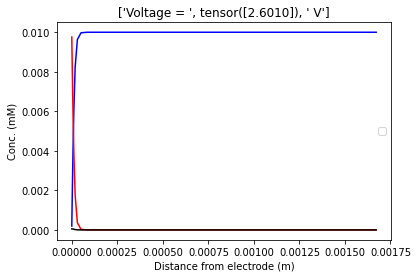

600 tensor([2.6010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


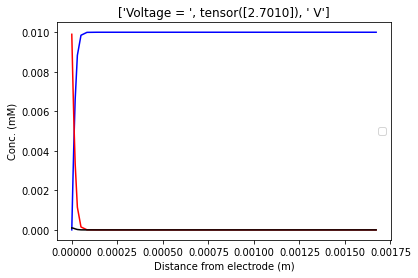

700 tensor([2.7010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


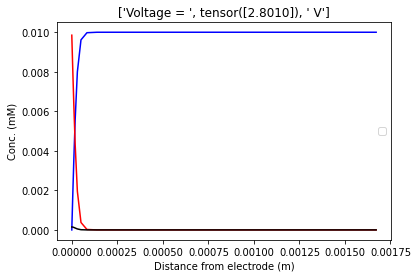

800 tensor([2.8010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


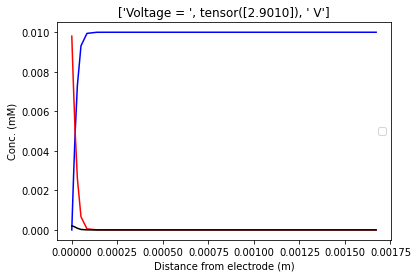

900 tensor([2.9010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


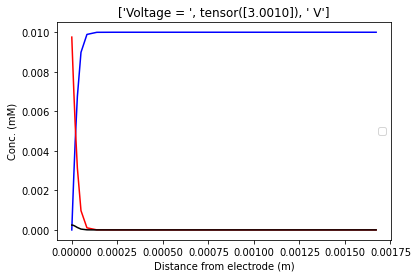

1000 tensor([3.0010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


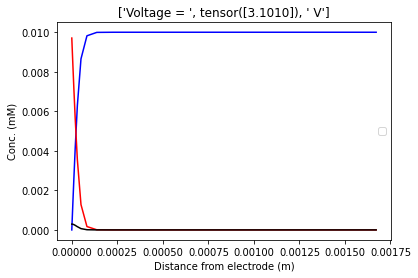

1100 tensor([3.1010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


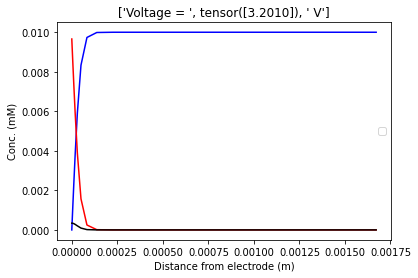

1200 tensor([3.2010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


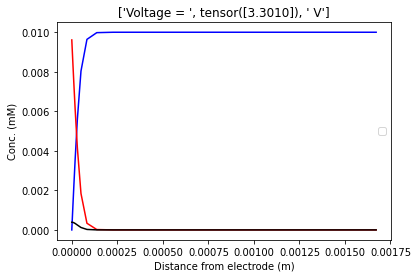

1300 tensor([3.3010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


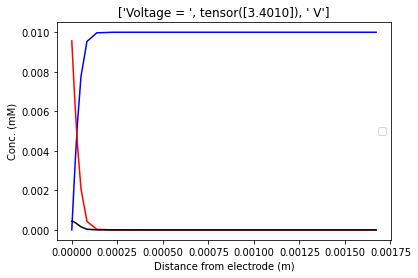

1400 tensor([3.4010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


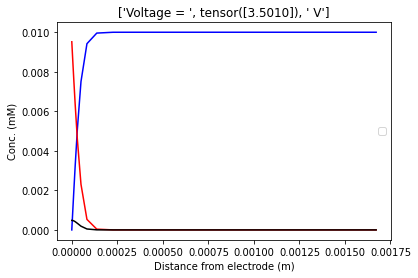

1500 tensor([3.5010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


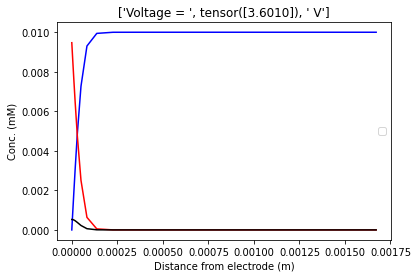

1600 tensor([3.6010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


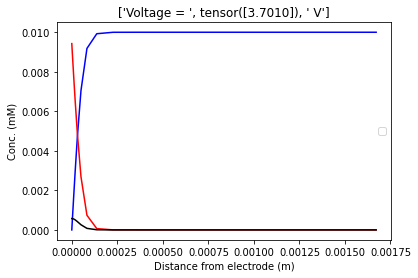

1700 tensor([3.7010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


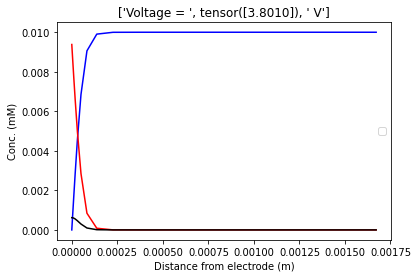

1800 tensor([3.8010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


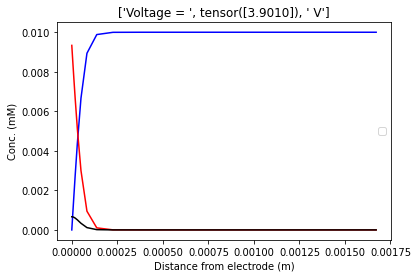

1900 tensor([3.9010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


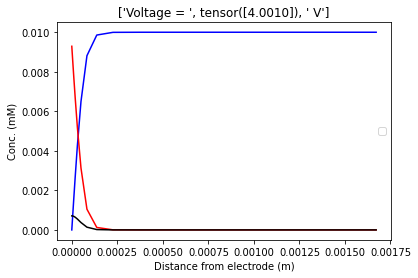

2000 tensor([4.0010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


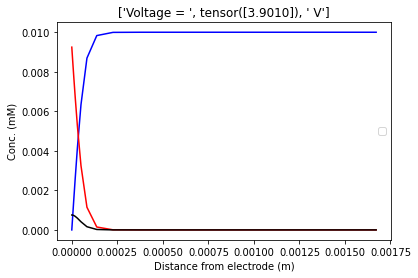

2100 tensor([3.9010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


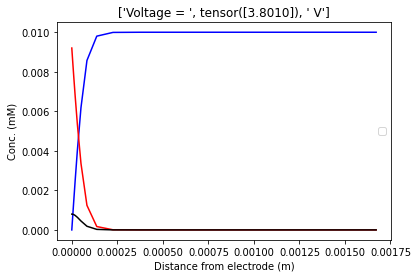

2200 tensor([3.8010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


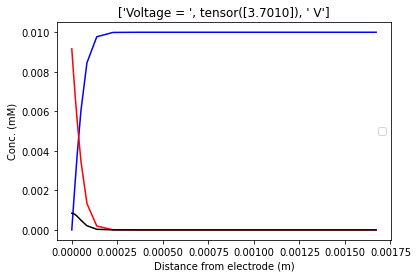

2300 tensor([3.7010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


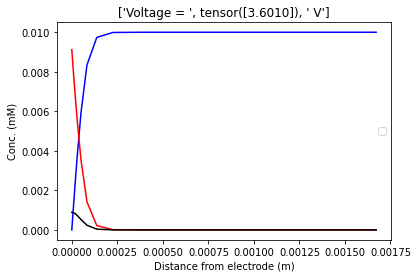

2400 tensor([3.6010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


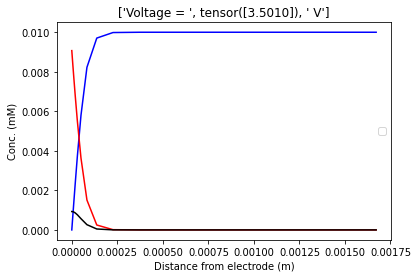

2500 tensor([3.5010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


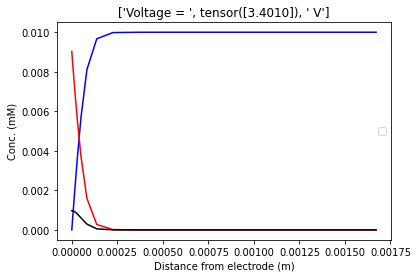

2600 tensor([3.4010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


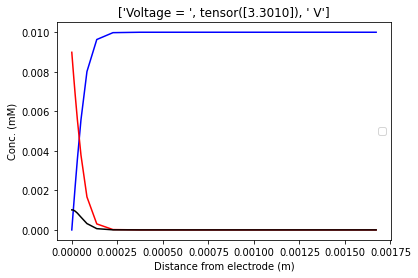

2700 tensor([3.3010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


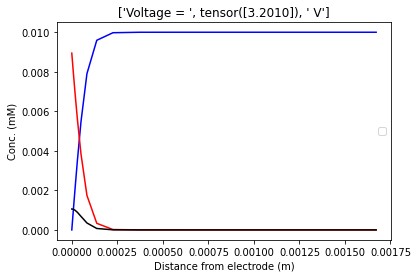

2800 tensor([3.2010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


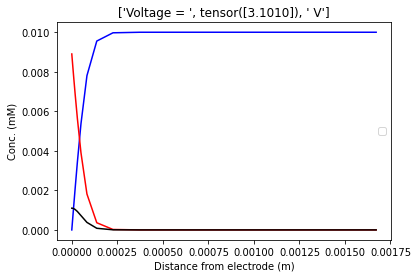

2900 tensor([3.1010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


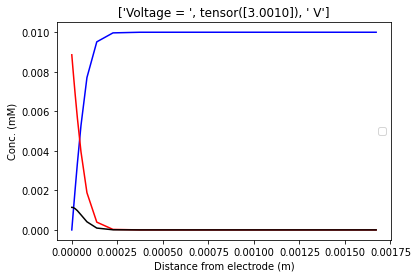

3000 tensor([3.0010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


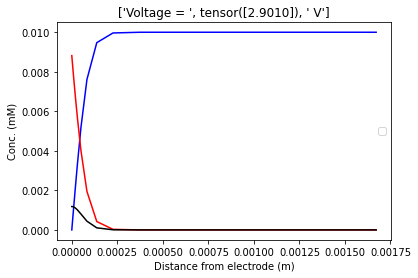

3100 tensor([2.9010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


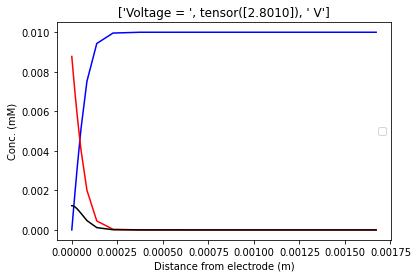

3200 tensor([2.8010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


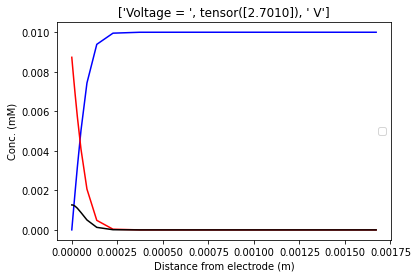

3300 tensor([2.7010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


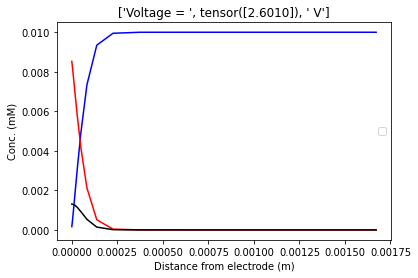

3400 tensor([2.6010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


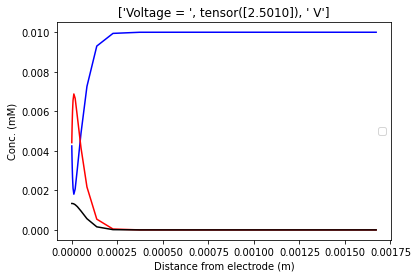

3500 tensor([2.5010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


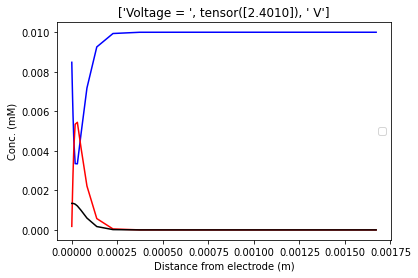

3600 tensor([2.4010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


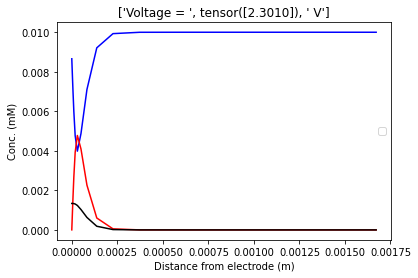

3700 tensor([2.3010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


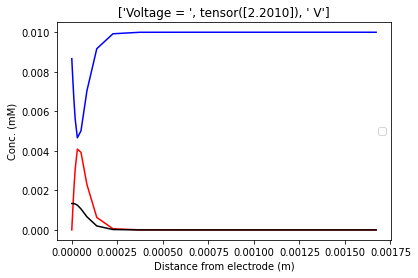

3800 tensor([2.2010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


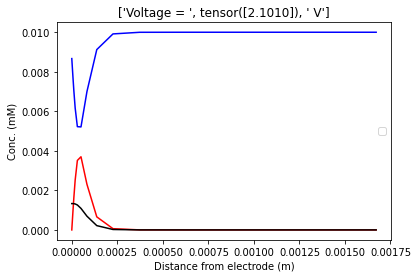

3900 tensor([2.1010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


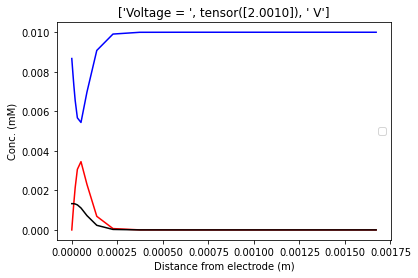

4000 tensor([2.0010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


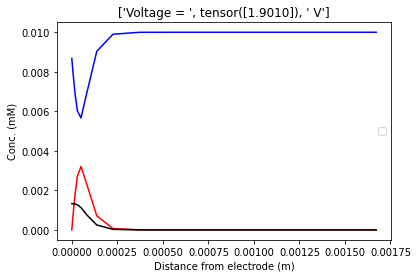

4100 tensor([1.9010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


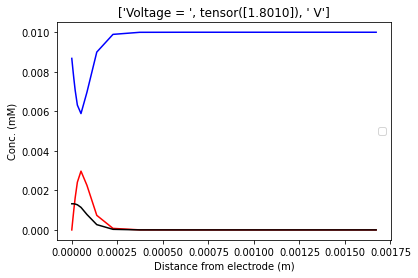

4200 tensor([1.8010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


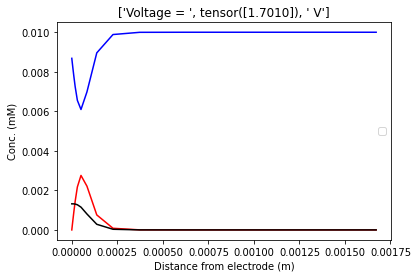

4300 tensor([1.7010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


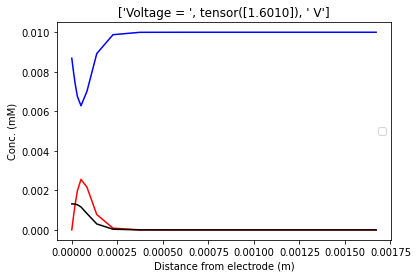

4400 tensor([1.6010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


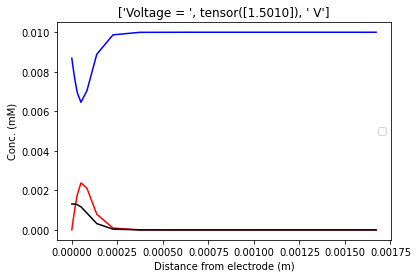

4500 tensor([1.5010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


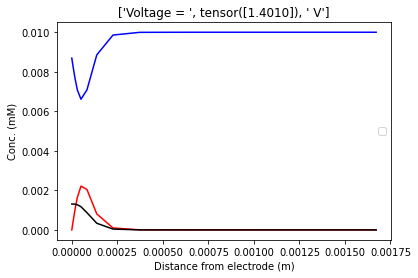

4600 tensor([1.4010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


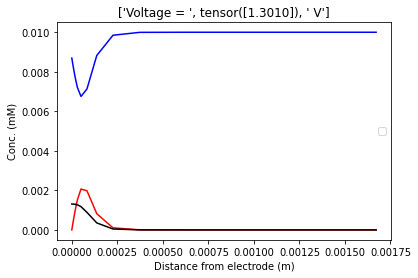

4700 tensor([1.3010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


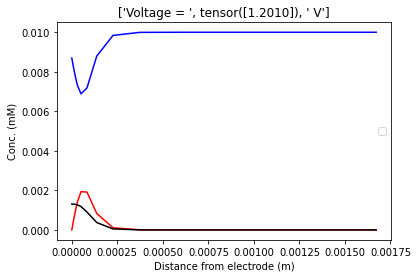

4800 tensor([1.2010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


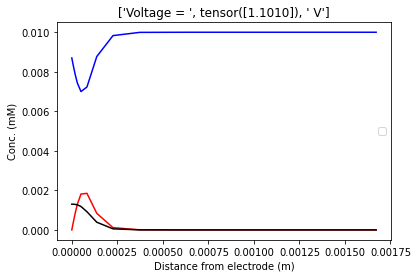

4900 tensor([1.1010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


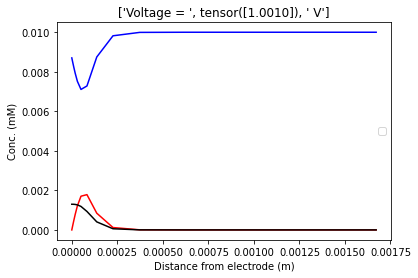

5000 tensor([1.0010])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


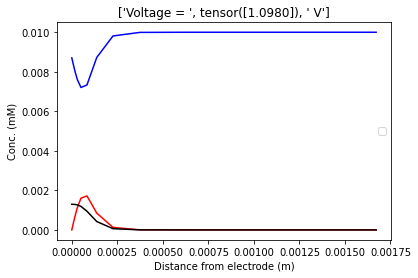

5100 tensor([1.0980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


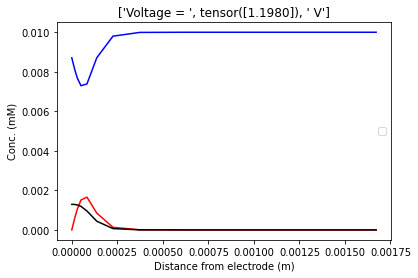

5200 tensor([1.1980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


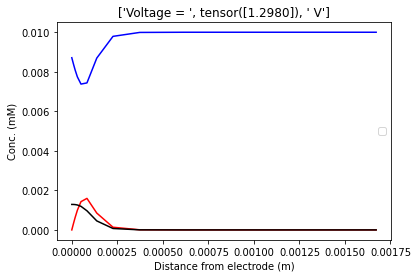

5300 tensor([1.2980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


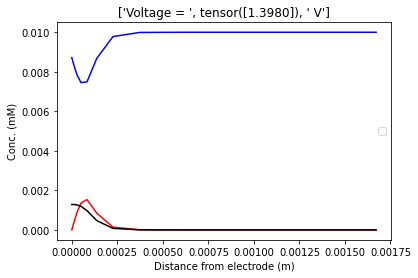

5400 tensor([1.3980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


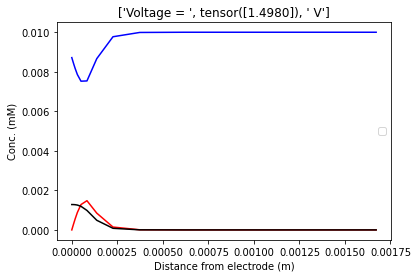

5500 tensor([1.4980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


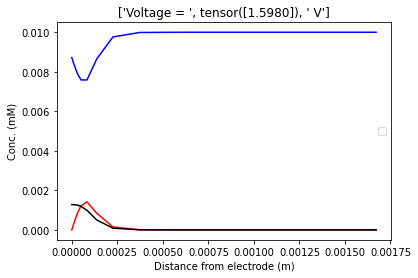

5600 tensor([1.5980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


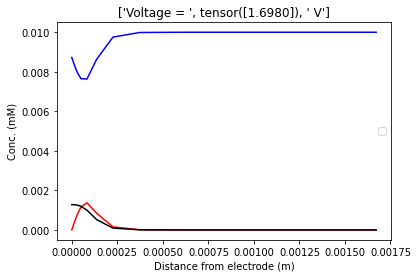

5700 tensor([1.6980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


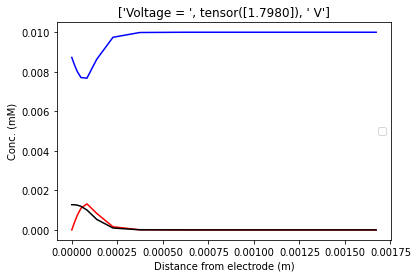

5800 tensor([1.7980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


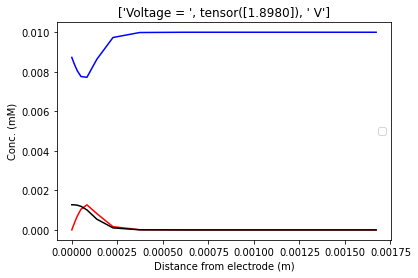

5900 tensor([1.8980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


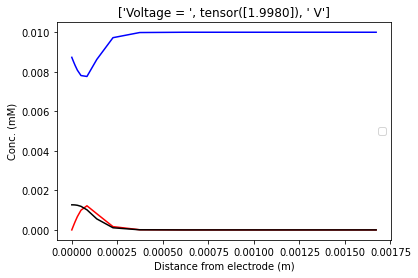

6000 tensor([1.9980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


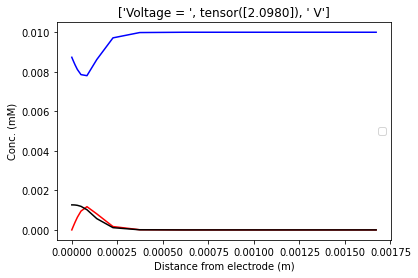

6100 tensor([2.0980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


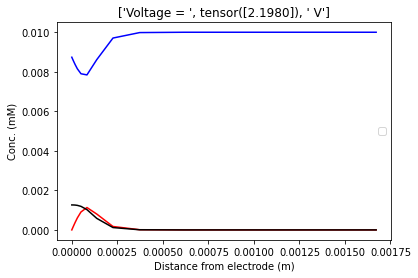

6200 tensor([2.1980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


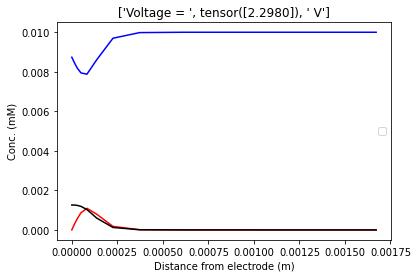

6300 tensor([2.2980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


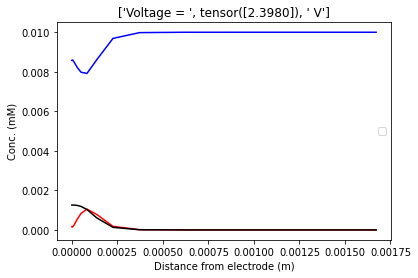

6400 tensor([2.3980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


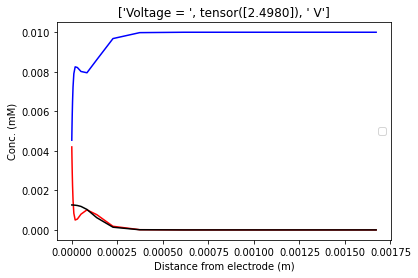

6500 tensor([2.4980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


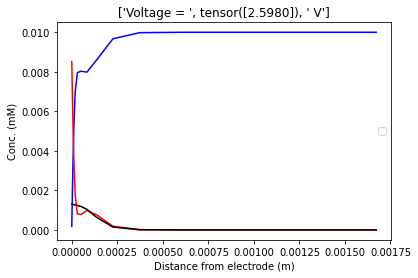

6600 tensor([2.5980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


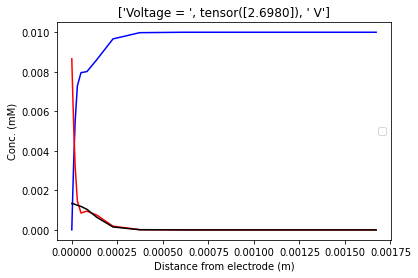

6700 tensor([2.6980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


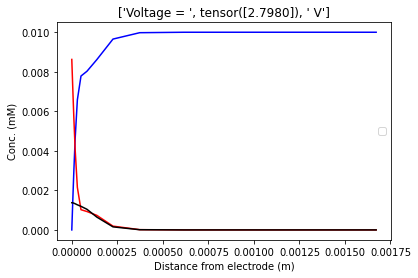

6800 tensor([2.7980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


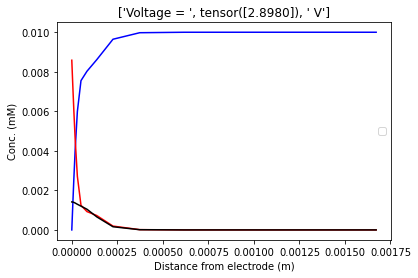

6900 tensor([2.8980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


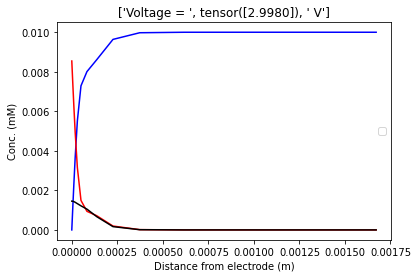

7000 tensor([2.9980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


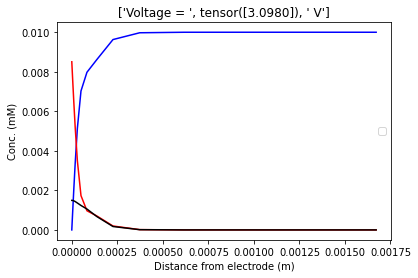

7100 tensor([3.0980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


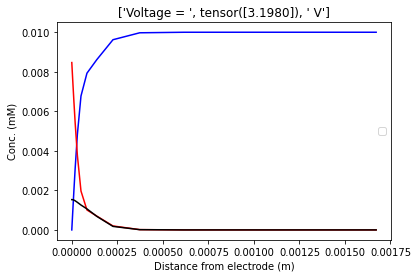

7200 tensor([3.1980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


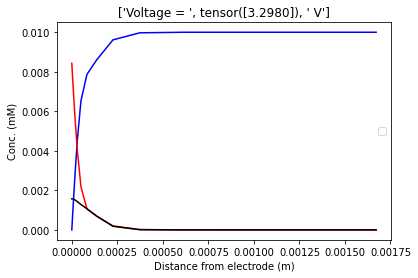

7300 tensor([3.2980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


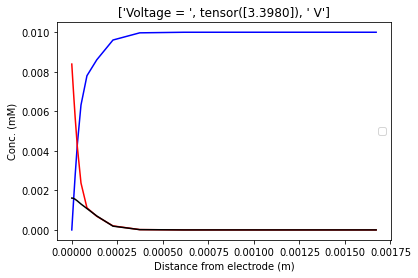

7400 tensor([3.3980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


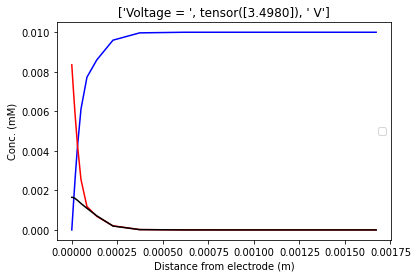

7500 tensor([3.4980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


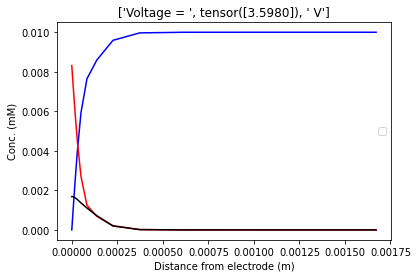

7600 tensor([3.5980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


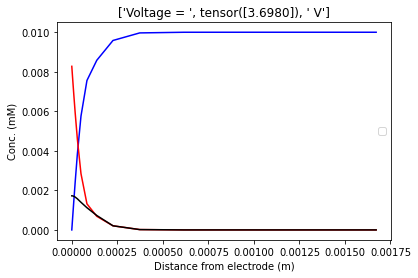

7700 tensor([3.6980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


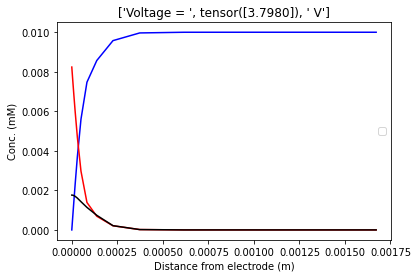

7800 tensor([3.7980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


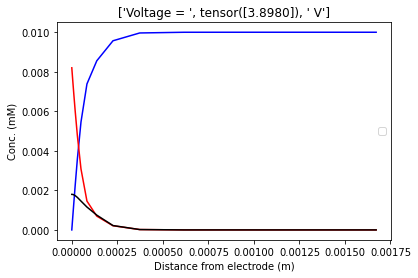

7900 tensor([3.8980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


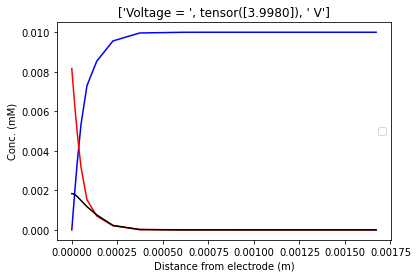

8000 tensor([3.9980])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


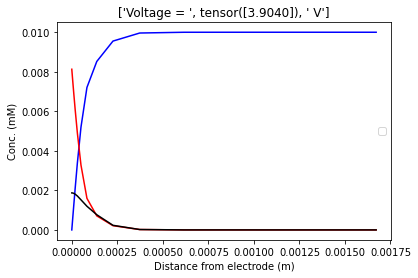

8100 tensor([3.9040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


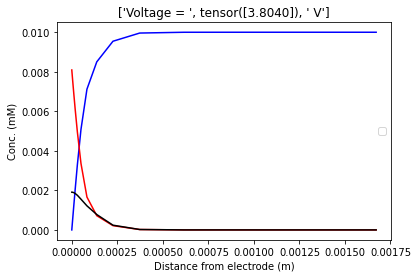

8200 tensor([3.8040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


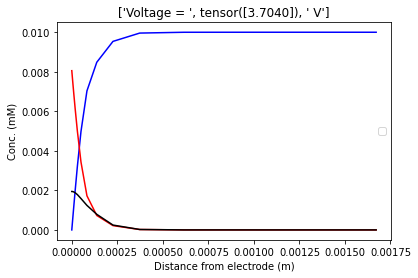

8300 tensor([3.7040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


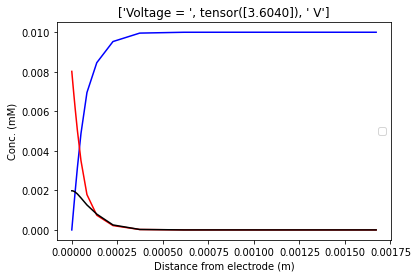

8400 tensor([3.6040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


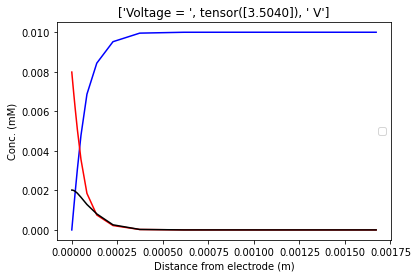

8500 tensor([3.5040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


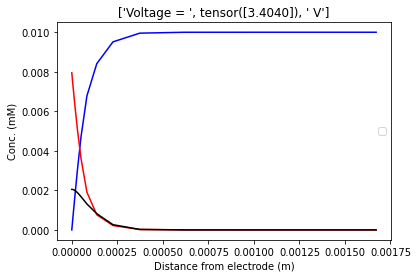

8600 tensor([3.4040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


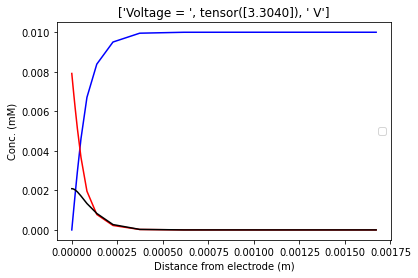

8700 tensor([3.3040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


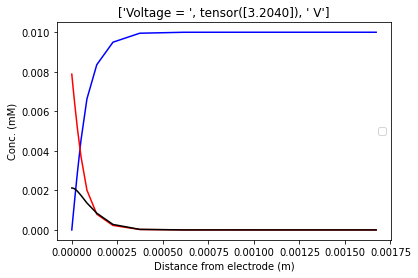

8800 tensor([3.2040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


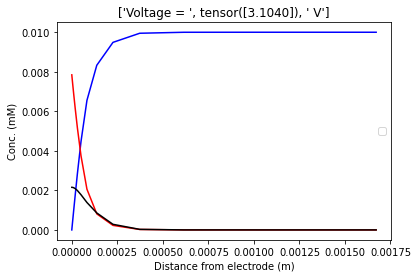

8900 tensor([3.1040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


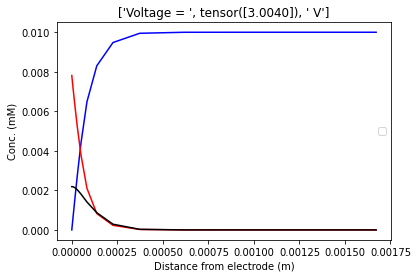

9000 tensor([3.0040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


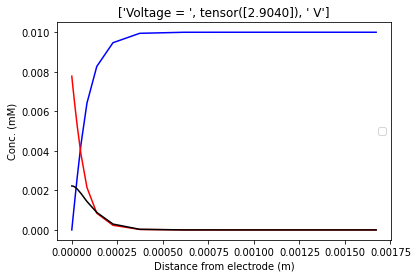

9100 tensor([2.9040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


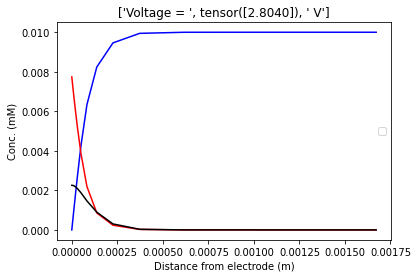

9200 tensor([2.8040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


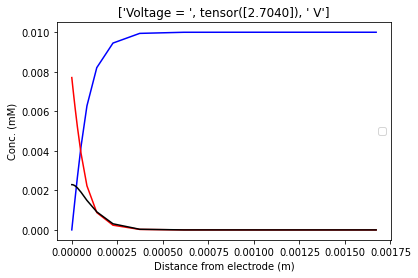

9300 tensor([2.7040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


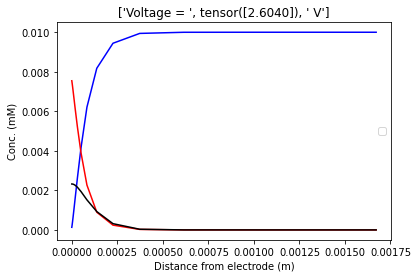

9400 tensor([2.6040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


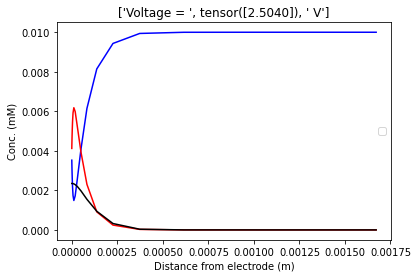

9500 tensor([2.5040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


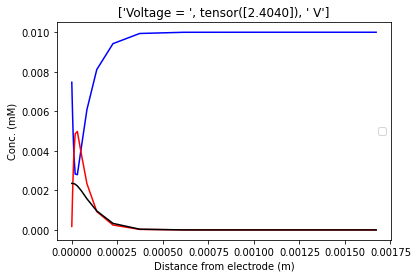

9600 tensor([2.4040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


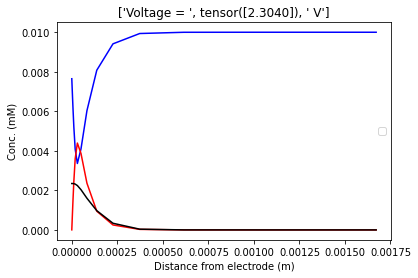

9700 tensor([2.3040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


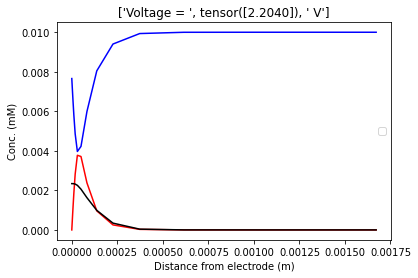

9800 tensor([2.2040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


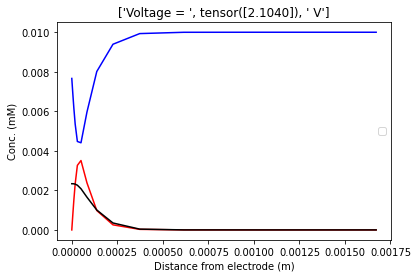

9900 tensor([2.1040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


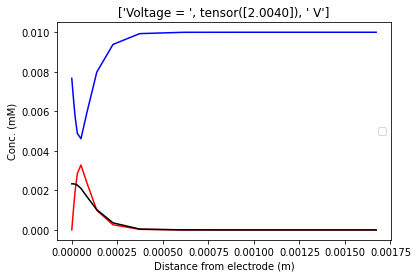

10000 tensor([2.0040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


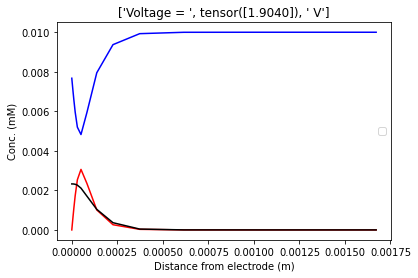

10100 tensor([1.9040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


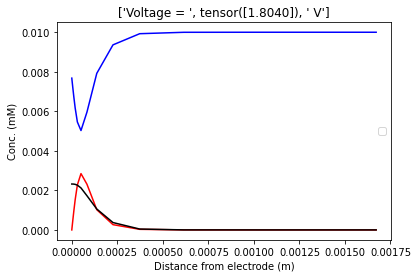

10200 tensor([1.8040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


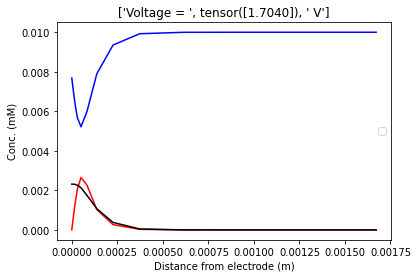

10300 tensor([1.7040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


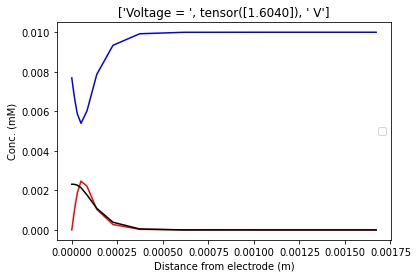

10400 tensor([1.6040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


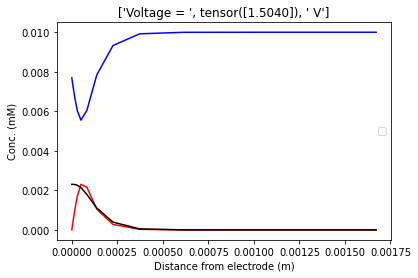

10500 tensor([1.5040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


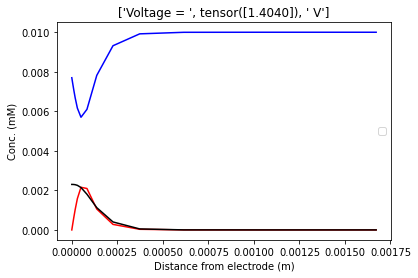

10600 tensor([1.4040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


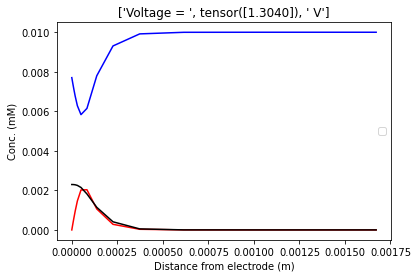

10700 tensor([1.3040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


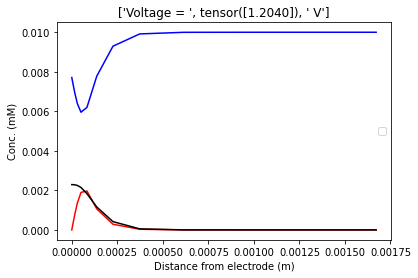

10800 tensor([1.2040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


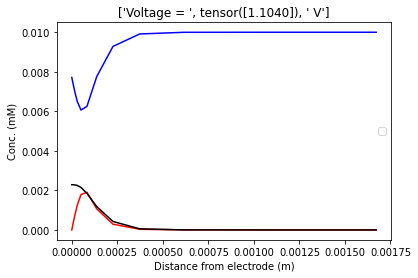

10900 tensor([1.1040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


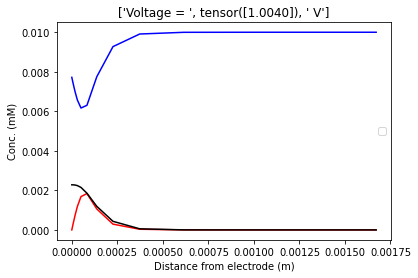

11000 tensor([1.0040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


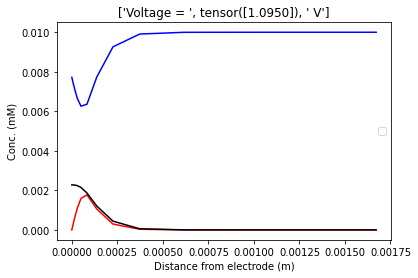

11100 tensor([1.0950])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


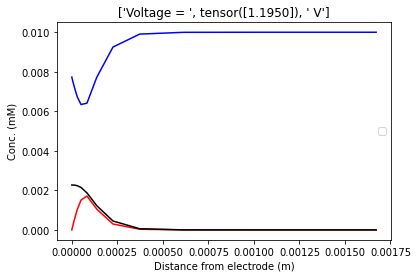

11200 tensor([1.1950])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


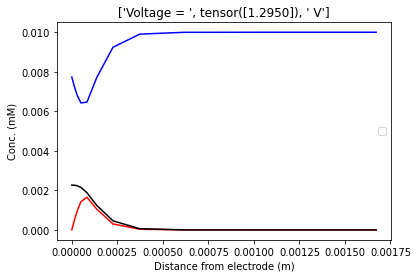

11300 tensor([1.2950])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


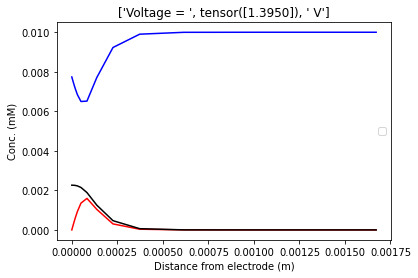

11400 tensor([1.3950])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


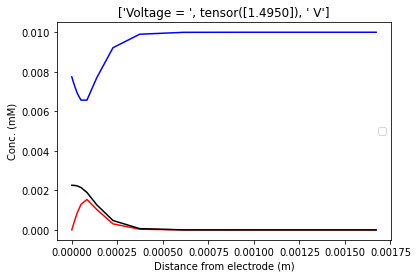

11500 tensor([1.4950])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


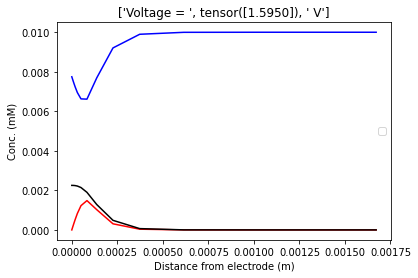

11600 tensor([1.5950])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


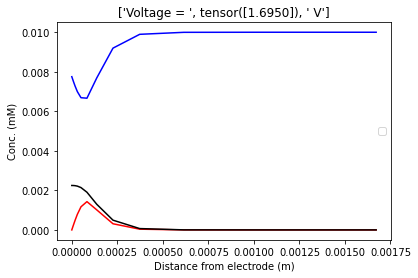

11700 tensor([1.6950])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


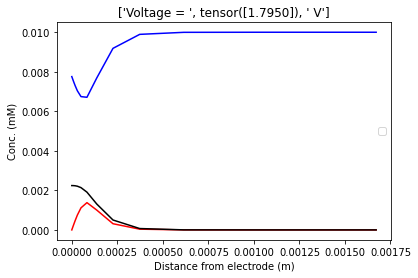

11800 tensor([1.7950])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


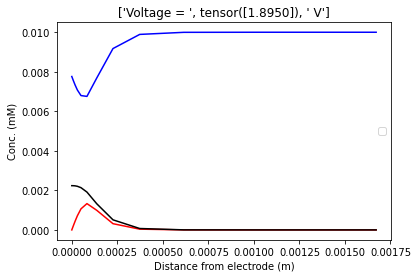

11900 tensor([1.8950])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


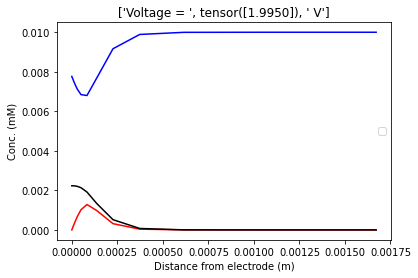

12000 tensor([1.9950])


In [ ]:
for E in Evt:
  k1f = ks * math.exp((E-E0)*VT) * dx1 / DR
  k1b = ks * math.exp(-(E-E0)*VT) * dx1 / DP
  
  #set values for row 0
  Dopt[0] = 0
  Dopt[0, 0] = math.exp(n * F * (E - E0) / (R * T))
  Dopt[0, N+1] = - 1

  for i in range(N+2, 2*N+1):
    Dopt[i] = 0
    Dopt[i, i] = D3[i-N-2] + k2fs
    Dopt[i, i-1] = -D1[i-N-2]
    Dopt[i, i+1] = -D2[i-N-2]
    Dopt[i, i+N+1] = -2 * k2bs * Cold1[i-N-1]

  for i in range(2*N+3, 3*N+2):
    Dopt[i] = 0
    Dopt[i, i] = D3[i-2*N-3] + 2 * k2bs * Cold1[i-2*N-2]
    Dopt[i, i-1] = -D1[i-2*N-3]
    Dopt[i, i+1] = -D2[i-2*N-3]
    Dopt[i, i-N-1] = -k2fs

  Cnew, LU = torch.solve(Cold, Dopt)
  Cnew[Cnew.lt(0)] = 0
  Cnew[Cnew.gt(0.01)] = 0.01

  Istor[count,:] = DR*F*(Cnew[1] - Cnew[0])/dx1
  #print(E,k1f,k1b,Cnew[0],Istor[count,:])

  if count % 100 == 0:
         plt.figure(count)
         plt.plot(x[0:(N+1)],Cnew[0:(N+1)],'-b')
         plt.plot(x[(N+1):(2*N+2)],Cnew[(N+1):(2*N+2)],'-r')
         plt.plot(x[(2*N+2)::],Cnew[(2*N+2)::],'-k')
         plt.title(['Voltage = ',E,' V'])
         plt.ylabel('Conc. (mM)')
         plt.xlabel('Distance from electrode (m)')
         plt.legend((1,2),('Reactant','Product'),loc=5)
         plt.show()
         print(count,E)
  
  Cold[0:N] = Cnew[0:N]
  Cold0[0:N] = Cnew[(N+1) : (2*N+1)]
  Cold1[0:N] = Cnew[(2*N+2) : (3*N+2)]
  Cold[(N+1) : (2*N+1)] = Cold0[0:N] - k2bs * Cold1[0:N] * Cold1[0:N]
  Cold[(2*N+2) : (3*N+2)] = Cold1[0:N] + k2bs * Cold1[0:N] * Cold1[0:N]
  
  Cold[0] = 0
  Cold[N+1] = 0
  Cold[2*N+2] = 0
  Cold[N] = CR0
  Cold[2*N+1] = CP00
  Cold[3*N+2] = CP10

  count = count + 1

In [ ]:
Cnew_test, LU = torch.solve(Cold, Dopt)
print(torch.dist(Cold.double(), torch.mm(Dopt.double(),Cnew_test.double())))

tensor(6.5537e-12, dtype=torch.float64)


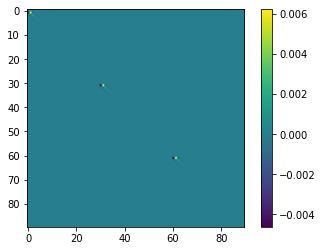

In [ ]:
plt.imshow((Dopt/(1e9)).tolist())
plt.colorbar()

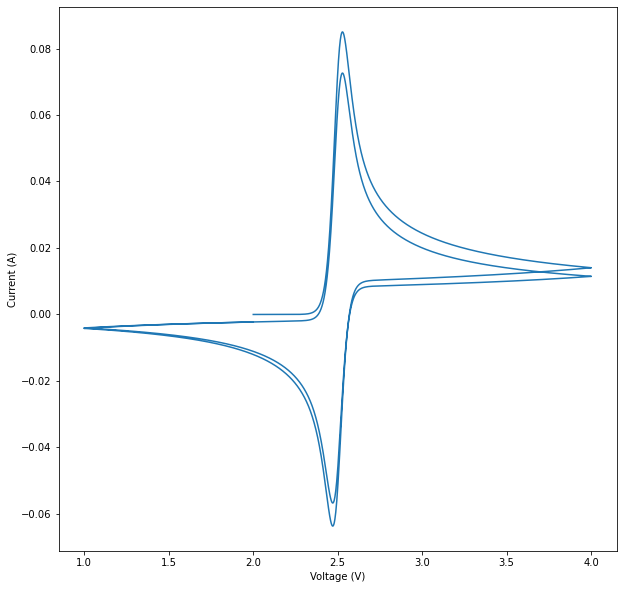

In [ ]:
plt.figure(figsize=(10,10))    
plt.plot(Evt,Istor)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.show()

In [ ]:
Evt_tensor = Evt.view(-1)
Istor_tensor = Istor.view(-1)
#Istor_tensor[Evt_tensor.le(2.0)] = 0
max_val, max_idx = Istor_tensor.max(0)
min_val, min_idx = Istor_tensor.min(0)
print ('max Evt', Evt_tensor[max_idx], 'max Istor', Istor_tensor[max_idx])
print ('min Evt', Evt_tensor[min_idx], 'min Istor', Istor_tensor[min_idx])

max Evt tensor(2.5290) max Istor tensor(0.0850)
min Evt tensor(2.4710) min Istor tensor(-0.0637)
